# Skin diseases prediction using various deep neural networks
Here, I will be implementing various deep learning architectures to classify thirteen different types of skin diseases.
The target of this experiment is to compare various models on various parameters to draw possible conclusions about architectures.
Models implemented here are:
1. TinyVGG (without augmentation)
2. TinyVGG (with augmentation)
3. MobileNet
4. DenseNet
5. VGG19
6. Vision Transformers
<br>
As data is medical data, it is difficult to generate synthetic data which accurately represents specific diseases. That is why, I will be using resampling if required. Transfer learning will be used for some models while some will be trained from scratch.
<br>
Experiment is designed in a way that code can be understood easily with well written documentation following all methods of writing code suggested in PEP 8 style of python programming.
<br>
As this is experiment setup, code is in notebook. Once results are derived, code can be converted in modular format and packaged to be delievered for easy usage.

## 0. Setting up machine for experiment

In [1]:
import torch
from torch import nn

torch.__version__

'2.0.0+cu117'

Now, as experiment should run on both CPU as well as GPU machines, I will set device which can be done directly with PyTorch.

In [25]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

I have GPU set in my machine which is represented by CUDA in PyTorch (CUDA is NVIDIA GPU computing toolkit).

## 1. Setting up data
As I am working on skin disease dataset, I need to use custom dataset (There is no pre-loaded dataset in PyTorch for this specific as per my knowledge.). I will be writing my own dataset process function which will be inherited from Dataset module of PyTorch so I get some pre-built functionality from module directly.
<br>
Format of data is:
|Dataset<br>
|--train<br>
|--|--Disease 1<br>
|--|--|--img_1.png<br>
|--|--|--img_2.png<br>
|--|--|--  &ensp;  .<br>
|--|--|--  &ensp;  .<br>
|--|--Disease 2<br>
|--|--|--img_1.png<br>
|--|--|--img_2.png<br>
|--|--|--    &ensp;.<br>
|--|--|--    &ensp;.<br>
|--|--   &ensp; .<br>
|--|--   &ensp; .<br>
|--|--Disease 9<br>
|--|--|--img_1.png<br>
|--|--|--img_2.png<br>
|--|--|--  &ensp;  .<br>
|--|--|--  &ensp;  .<br>
|--test<br>
|--|--Disease 1<br>
|--|--|--img_1.png<br>
|--|--|--img_2.png<br>
|--|--|--  &ensp;  .<br>
|--|--|--  &ensp;  .<br>
|--|--Disease 2<br>
|--|--|--img_1.png<br>
|--|--|--img_2.png<br>
|--|--|--  &ensp;  .<br>
|--|--|--  &ensp;  .<br>
|--|--  &ensp;  .<br>
|--|--  &ensp;  .<br>
|--|--Disease 9<br>
|--|--|--img_1.png<br>
|--|--|--img_2.png<br>
|--|--|--   &ensp; .<br>
|--|--|--   &ensp; .<br>

In [26]:
import os

def walk_through_dir(dir_path):
    """
    Walks through dir_path returning its contents.
    Args:
    dir_path (str or pathlib.Path): target directory

    Returns:
    A print out of:
        number of subdiretories in dir_path
        number of images (files) in each subdirectory
        name of each subdirectory
    """
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [27]:
walk_through_dir('Dataset')

There are 2 directories and 0 images in 'Dataset'.
There are 13 directories and 0 images in 'Dataset\test'.
There are 0 directories and 231 images in 'Dataset\test\Acne and Rosacea Photos'.
There are 0 directories and 120 images in 'Dataset\test\Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions'.
There are 1 directories and 24 images in 'Dataset\test\Atopic Dermatitis Photos'.
There are 0 directories and 204 images in 'Dataset\test\Atopic Dermatitis Photos\Acne and Rosacea Photos'.
There are 0 directories and 14 images in 'Dataset\test\Cellulitis Impetigo and other Bacterial Infections'.
There are 0 directories and 30 images in 'Dataset\test\Light Diseases and Disorders of Pigmentation'.
There are 0 directories and 25 images in 'Dataset\test\Lupus and other Connective Tissue diseases'.
There are 0 directories and 13 images in 'Dataset\test\Poison Ivy Photos and other Contact Dermatitis'.
There are 0 directories and 24 images in 'Dataset\test\Psoriasis pictures Lichen P

We have different number of images per class but we will decide its effect once we train few models. Till than we will go with augmentations only.

In [2]:
from pathlib import Path

image_path = Path('Dataset/')
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(WindowsPath('Dataset/train'), WindowsPath('Dataset/test'))

### 1.1 Visualization of data
Here, I will be writing function to visualize random image from dataset.

3141
Random image path: Dataset\train\Systemic Disease\neurofibromatosis-10.jpg
Image class: Systemic Disease
Image height: 476
Image width: 720


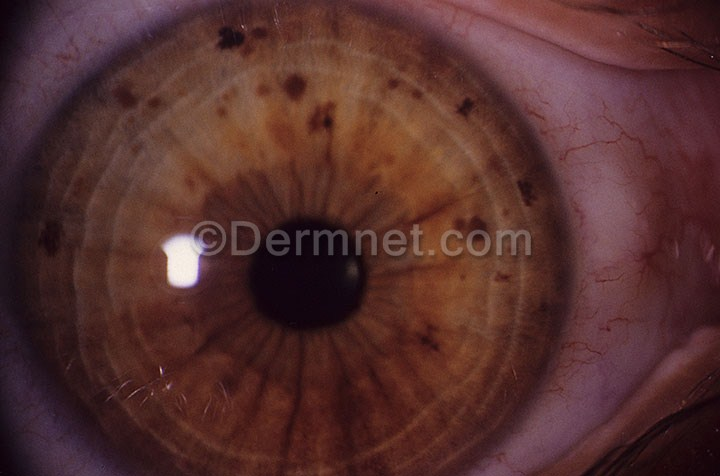

In [29]:
import random
from PIL import Image

random.seed(42)

image_path_list = list(image_path.glob("*/*/*.jpg"))
print(len(image_path_list))

random_image_path = random.choice(image_path_list)
image_class = random_image_path.parent.stem

img = Image.open(random_image_path)

print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

## 2. Transforming data
Converting images to tensors.<br>
Loading them to Dataset and in Dataloader.

In [3]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [31]:
data_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

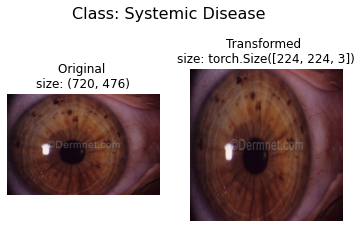

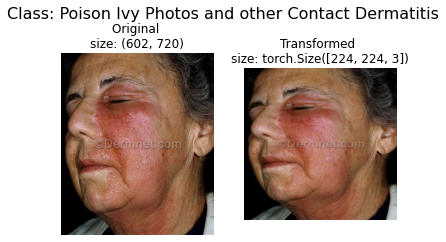

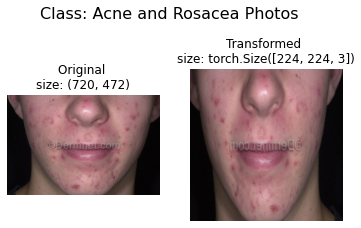

In [32]:
import matplotlib.pyplot as plt

def viz_trans_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1,2)
            ax[0].imshow(f)
            width, height = f.size
            ax[0].set_title(f"Original \nsize: {width, height}")
            ax[0].axis("off")

            transformed_image = transform(f).permute(1,2,0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nsize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

viz_trans_images(image_path_list, transform=data_transform, n=3)

In [33]:
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 2472
    Root location: Dataset\train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 873
    Root location: Dataset\test


In [34]:
class_names = train_data.classes
class_names

['Acne and Rosacea Photos',
 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions',
 'Atopic Dermatitis Photos',
 'Cellulitis Impetigo and other Bacterial Infections',
 'Light Diseases and Disorders of Pigmentation',
 'Lupus and other Connective Tissue diseases',
 'Poison Ivy Photos and other Contact Dermatitis',
 'Psoriasis pictures Lichen Planus and related diseases',
 'Seborrheic Keratoses and other Benign Tumors',
 'Systemic Disease',
 'Tinea Ringworm Candidiasis and other Fungal Infections',
 'Vascular Tumors',
 'Warts Molluscum and other Viral Infections']

In [35]:
class_dict = train_data.class_to_idx
class_dict

{'Acne and Rosacea Photos': 0,
 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions': 1,
 'Atopic Dermatitis Photos': 2,
 'Cellulitis Impetigo and other Bacterial Infections': 3,
 'Light Diseases and Disorders of Pigmentation': 4,
 'Lupus and other Connective Tissue diseases': 5,
 'Poison Ivy Photos and other Contact Dermatitis': 6,
 'Psoriasis pictures Lichen Planus and related diseases': 7,
 'Seborrheic Keratoses and other Benign Tumors': 8,
 'Systemic Disease': 9,
 'Tinea Ringworm Candidiasis and other Fungal Infections': 10,
 'Vascular Tumors': 11,
 'Warts Molluscum and other Viral Infections': 12}

In [36]:
# BATCH_SIZE = 32
# NUM_WORKERS = os.cpu_count()

# train_dataloader = DataLoader(dataset=train_data,
#                               batch_size=BATCH_SIZE,
#                               num_workers=NUM_WORKERS,
#                               shuffle=True)

# test_dataloader = DataLoader(dataset=test_data,
#                              batch_size=BATCH_SIZE,
#                              num_workers=NUM_WORKERS,
#                              shuffle=False)
# train_dataloader, test_dataloader

In [37]:
# img, label = next(iter(train_dataloader))

# print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
# print(f"Label shape: {label.shape}")

## Model 1: TinyVGG without data augmentation

Not having data augmentation done on data hence creating simple transform with resize only. 
> Note: Converting image to tensor is mendatory. 

In [38]:
simple_transform = transforms.Compose([ 
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [39]:
train_data_simple = datasets.ImageFolder(root=train_dir, transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir, transform=simple_transform)

In [40]:
import os
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

train_dataloader_simple = DataLoader(train_data_simple, 
                                     batch_size=BATCH_SIZE, 
                                     shuffle=True, 
                                     num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple, 
                                    batch_size=BATCH_SIZE, 
                                    shuffle=False, 
                                    num_workers=NUM_WORKERS)

train_dataloader_simple, test_dataloader_simple

Creating DataLoader's with batch size 32 and 12 workers.


(<torch.utils.data.dataloader.DataLoader at 0x1a6af343310>,
 <torch.utils.data.dataloader.DataLoader at 0x1a6af3434f0>)

In [41]:
class TinyVGG(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*56*56, 
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)

        return x

torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device=device)

model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=31360, out_features=13, bias=True)
  )
)

Trying simple forward pass on single image to test if model is working fine or not.<br>

In [42]:
img_batch, label_batch = next(iter(train_dataloader_simple))

img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

model_0.eval()
with torch.inference_mode():
    pred = model_0(img_single.to(device))
    
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 3, 224, 224])

Output logits:
tensor([[ 0.0453,  0.0441, -0.0283, -0.0432,  0.0389, -0.0195,  0.0332, -0.0385,
          0.0595, -0.0117,  0.0190, -0.0432,  0.0287]], device='cuda:0')

Output prediction probabilities:
tensor([[0.0799, 0.0798, 0.0742, 0.0731, 0.0794, 0.0749, 0.0790, 0.0735, 0.0811,
         0.0755, 0.0778, 0.0731, 0.0786]], device='cuda:0')

Output prediction label:
tensor([8], device='cuda:0')

Actual label:
0


In [43]:
import torchinfo

from torchinfo import summary
summary(model_0, input_size=[1, 3, 224, 224])

c:\Users\siddh\AppData\Local\Programs\Python\Python39\lib\site-packages\torchinfo\torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
c:\Users\siddh\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 13]                   --
├─Sequential: 1-1                        [1, 10, 112, 112]         --
│    └─Conv2d: 2-1                       [1, 10, 224, 224]         280
│    └─ReLU: 2-2                         [1, 10, 224, 224]         --
│    └─Conv2d: 2-3                       [1, 10, 224, 224]         910
│    └─ReLU: 2-4                         [1, 10, 224, 224]         --
│    └─MaxPool2d: 2-5                    [1, 10, 112, 112]         --
├─Sequential: 1-2                        [1, 10, 56, 56]           --
│    └─Conv2d: 2-6                       [1, 10, 112, 112]         910
│    └─ReLU: 2-7                         [1, 10, 112, 112]         --
│    └─Conv2d: 2-8                       [1, 10, 112, 112]         910
│    └─ReLU: 2-9                         [1, 10, 112, 112]         --
│    └─MaxPool2d: 2-10                   [1, 10, 56, 56]           --
├─Sequentia

In [44]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    model.train()
    
    train_loss, train_acc = 0, 0
    
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [45]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    model.eval() 
    
    test_loss, test_acc = 0, 0
    
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
    
            test_pred_logits = model(X)

            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [46]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [47]:
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_0 
model_0_results = train(model=model_0, 
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.2432 | train_acc: 0.3313 | test_loss: 2.3888 | test_acc: 0.2578
Epoch: 2 | train_loss: 2.1599 | train_acc: 0.3413 | test_loss: 2.3780 | test_acc: 0.2578
Epoch: 3 | train_loss: 2.1430 | train_acc: 0.3389 | test_loss: 2.4007 | test_acc: 0.2578
Epoch: 4 | train_loss: 2.1017 | train_acc: 0.3389 | test_loss: 2.3758 | test_acc: 0.2623
Epoch: 5 | train_loss: 2.0773 | train_acc: 0.3409 | test_loss: 2.4256 | test_acc: 0.2634
Total training time: 391.784 seconds


In [48]:
from typing import Tuple, Dict, List

def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

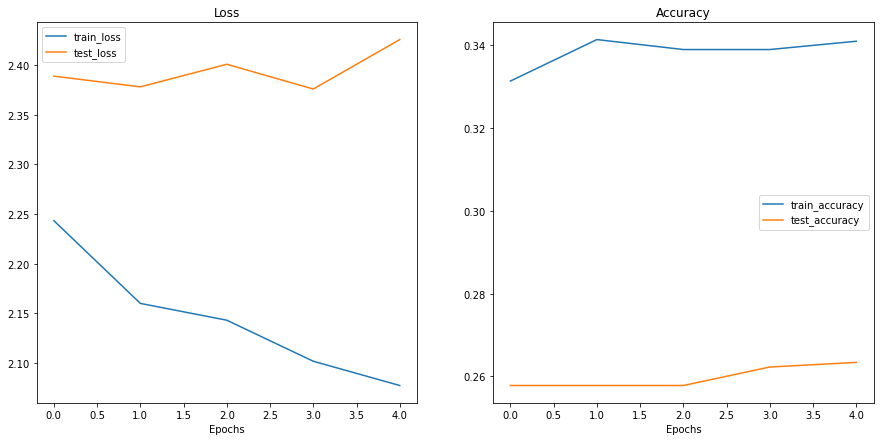

In [49]:
plot_loss_curves(model_0_results)

## TinyVGG with data augmentation

In [4]:
train_transform_trivial_augment = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor() 
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [5]:
train_data_augmented = datasets.ImageFolder(train_dir, transform=train_transform_trivial_augment)
test_data_simple = datasets.ImageFolder(test_dir, transform=test_transform)

train_data_augmented, test_data_simple

(Dataset ImageFolder
     Number of datapoints: 2472
     Root location: Dataset\train
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 873
     Root location: Dataset\test
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            ))

In [6]:
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(train_data_augmented, 
                                        batch_size=1, 
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple, 
                                    batch_size=1, 
                                    shuffle=False, 
                                    num_workers=NUM_WORKERS)

train_dataloader_augmented, test_dataloader_simple

(<torch.utils.data.dataloader.DataLoader at 0x197d9cb28e0>,
 <torch.utils.data.dataloader.DataLoader at 0x197b6a0cfa0>)

In [53]:
torch.manual_seed(42)
model_1 = TinyVGG(
    input_shape=3,
    hidden_units=10,
    output_shape=len(train_data_augmented.classes)).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=31360, out_features=13, bias=True)
  )
)

In [54]:
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

NUM_EPOCHS = 5

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

from timeit import default_timer as timer 
start_time = timer()

model_1_results = train(model=model_1, 
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.2165 | train_acc: 0.3305 | test_loss: 2.4361 | test_acc: 0.2578
Epoch: 2 | train_loss: 2.1714 | train_acc: 0.3401 | test_loss: 2.4053 | test_acc: 0.2578
Epoch: 3 | train_loss: 2.1556 | train_acc: 0.3377 | test_loss: 2.3915 | test_acc: 0.2567
Epoch: 4 | train_loss: 2.1233 | train_acc: 0.3357 | test_loss: 2.4016 | test_acc: 0.2589
Epoch: 5 | train_loss: 2.1116 | train_acc: 0.3373 | test_loss: 2.4038 | test_acc: 0.2567
Total training time: 371.530 seconds


In [55]:
torch.save(model_0, 'model_0.pth')
torch.save(model_1, 'model_1.pth')

As visible, TinyVGG gives very bad results because it is very small network with small number of parameters and hence cannot learn when number of classes are so high. Now for comparison of deep network, I will be training EfficientNet for same task with data-augmentation. <br>
EfficientNet is very popular model architecture and hence it is available in `torchvision` library.